# fNP intro & purpose

This noteboook is to test the fNP module in `modules/fNP.py`.

# imports

In [1]:
# Import required libraries
import torch
import matplotlib.pyplot as plt

# Import costum modules
import modules.utilities as utl
import modules.fNP as fNP

# fNP setup

## Load config file

In [2]:
# Load the configuration from a YAML file
config_file_path = 'config/config.yaml'
config = utl.load_yaml_config(config_file_path)

## instantiate the model & define (x, b)

In [3]:
# Instantiate the model.
# The object model_fNP itself is not just a dictionary; 
# it is an nn.Module that contains an nn.ModuleDict as one of its attributes.
model_fNP = fNP.fNP(config)

Initializing shared g2 with value 0.25.


In [4]:
# Define example inputs.
x = torch.tensor(0.3)
b = torch.tensor(1.0)

# Explicit vector inputs.
xv = torch.tensor([0.0001, 0.002, 0.03, 0.1, 0.3])
bv = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])

# To evaluate fNP on all combinations of values in two vectors 
# (for example, x values along one axis and b values along the other), 
# you’ll need to prepare your inputs accordingly, then create a mesh grid
x_values = torch.logspace(-5  , 0, steps=10)   # e.g., shape (10,)
b_values = torch.linspace(1e-5, 10, steps=10)  # e.g., shape (10,)

# Create a meshgrid of x and b values. X and B will each have shape (10, 10)
X, B = torch.meshgrid(x_values, b_values, indexing = 'ij')

# fNP functional forms in latex

$$
f(x,b) = N_{Pevol} \cdot \frac{
            g_1 \, \exp\left(-g_1\left(\frac{b}{2}\right)^2\right)
          + \lambda^2 \, g_{1B}^2 \left(1 - g_{1B}\left(\frac{b}{2}\right)^2\right)
            \exp\left(-g_{1B}\left(\frac{b}{2}\right)^2\right)
          + g_{1C} \, \lambda_2^2 \, \exp\left(-g_{1C}\left(\frac{b}{2}\right)^2\right)
        }{
            g_1 + \lambda^2 \, g_{1B}^2 + g_{1C} \, \lambda_2^2
        }
        \\
        \text{where } 
        \\
        g_1 = N_1 \left(\frac{x}{x_{\text{hat}}}\right)^{\sigma_1}
            \left(\frac{1-x}{1-x_{\text{hat}}}\right)^{\alpha_1^2},\\[1mm]
        \\    
        g_{1B} = N_{1B} \left(\frac{x}{x_{\text{hat}}}\right)^{\sigma_2}
            \left(\frac{1-x}{1-x_{\text{hat}}}\right)^{\alpha_2^2},\\[1mm]
        \\    
        g_{1C} = N_{1C} \left(\frac{x}{x_{\text{hat}}}\right)^{\sigma_3}
            \left(\frac{1-x}{1-x_{\text{hat}}}\right)^{\alpha_3^2},\quad
        \\    
        x_{\text{hat}} = 0.1.
$$

In [5]:
fNP_base = fNP.TMDPDFBase(n_flavors=1, init_params=[0.25, 0.15], free_mask=[True, True])
fNP_base.show_latex_formula

############################################################################################################
# other two equivalent ways to show the latex formula
############################################################################################################
# from IPython.display import Latex
# 
# Latex(fNP_base.latex_formula)
# utl.show_latex_formula(fNP_base.latex_formula)

<IPython.core.display.Latex object>

In [6]:
fNP_u = fNP.TMDPDF_u()
fNP_u.show_latex_formula

<IPython.core.display.Latex object>

In [7]:
fNP_d = fNP.TMDPDF_d()
fNP_d.show_latex_formula

<IPython.core.display.Latex object>

# Checks & tests

## fNP point by point $(x, b)$

Results for all flavors:
u: 0.9315702319145203
ubar: 0.3322105407714844
d: 0.9343553185462952
dbar: 0.3322105407714844
c: 0.8022000193595886
cbar: 0.8022000193595886
s: 0.8022000193595886
sbar: 0.8022000193595886


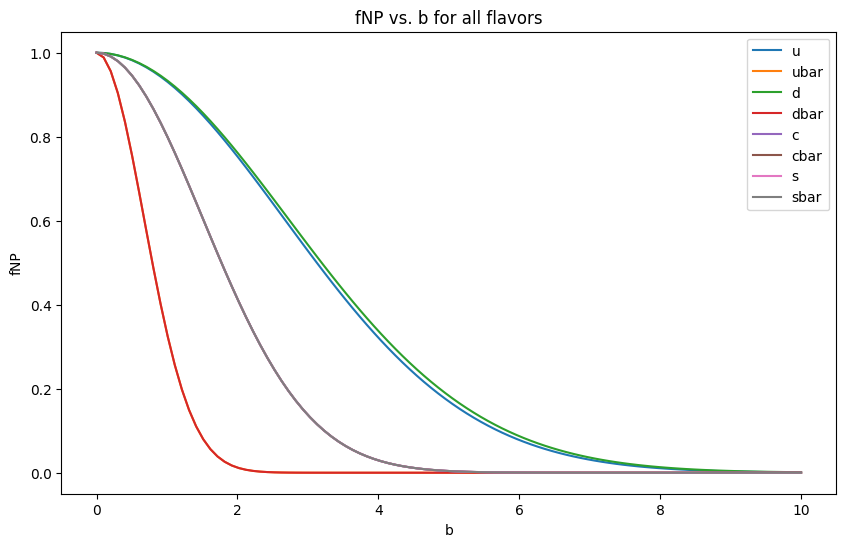

In [8]:
# Check
# Evaluate the model for all flavors (u, ubar, d, dbar, c, cbar, s, sbar).
results = model_fNP(x, b)
print("Results for all flavors:")
for flavor, val in results.items():
    print(f"{flavor}: {val.item()}")

# Call the plotting function.
utl.plot_fNP(model_fNP, x)

## fNP elementwise for x and b vectors
If x and b are both 1D tensors of the same shape (say, shape (N,)), then the result will also have shape (N,)

In [9]:
# For a given flavor, the forward method will be applied elementwise.
results = model_fNP(xv, bv)  # xv and bv have both shape (5,)

# 'results' is a dictionary mapping flavor keys to output tensors of shape (5,)
for flavor, output in results.items():
    print(f"Flavor: {flavor}, Output shape: {output.shape}")
    
# To see the output tensor for the "u" flavor, do:
print("Result tensor for flavor 'd':")
print(results['d'])     

Flavor: u, Output shape: torch.Size([5])
Flavor: ubar, Output shape: torch.Size([5])
Flavor: d, Output shape: torch.Size([5])
Flavor: dbar, Output shape: torch.Size([5])
Flavor: c, Output shape: torch.Size([5])
Flavor: cbar, Output shape: torch.Size([5])
Flavor: s, Output shape: torch.Size([5])
Flavor: sbar, Output shape: torch.Size([5])
Result tensor for flavor 'd':
tensor([0.9647, 0.8332, 0.6007, 0.3691, 0.1834], grad_fn=<MulBackward0>)


## fNP on a grid of x and b values

For a grid evaluation (Cartesian product): Use torch.meshgrid to generate 2D tensors for x and b. The output will then be a 2D tensor (with the shape of the grid).

In [10]:
# To evaluate fNP on all combinations of values in two vectors 
# (for example, x values along one axis and b values along the other), 
# you’ll need to prepare your inputs accordingly, then create a mesh grid.
x_values = torch.logspace(-5, 0, steps=10)   # e.g., shape (10,)
b_values = torch.linspace(1e-5, 10, steps=10)  # e.g., shape (10,)

# Check elements in the meshgrid
print("x_values:")
print(x_values)
print("b_values:")
print(b_values)

# Create a meshgrid of x and b values. X and B will each have shape (10, 10)
X, B = torch.meshgrid(x_values, b_values, indexing = 'ij')

# For a given flavor, the forward method will be applied on the mesh.
results = model_fNP(X, B)  # X and B have shape (10,10)

# 'results' is a dictionary mapping flavor keys to output tensors of shape (10,10)
# for flavor, output in results.items():
#     print(f"Flavor: {flavor}, Output shape: {output.shape}")
    
# To see the output tensor for the "u" flavor, do:
print("Result tensor for flavor 'd':")
print(results['d'])    

# Access individual elements of the output tensor for the "d" flavor.
print("Output tensor for flavor 'd' at (x=0.1, b=2.0):")
print(results['d'][3, 1])
print(results['d'][3, 1].item())

x_values:
tensor([1.0000e-05, 3.5938e-05, 1.2915e-04, 4.6416e-04, 1.6681e-03, 5.9948e-03,
        2.1544e-02, 7.7426e-02, 2.7826e-01, 1.0000e+00])
b_values:
tensor([1.0000e-05, 1.1111e+00, 2.2222e+00, 3.3333e+00, 4.4445e+00, 5.5556e+00,
        6.6667e+00, 7.7778e+00, 8.8889e+00, 1.0000e+01])
Result tensor for flavor 'd':
tensor([[1.0000, 0.9638, 0.8629, 0.7176, 0.5545, 0.3981, 0.2657, 0.1649, 0.0953,
         0.0513],
        [1.0000, 0.9600, 0.8493, 0.6925, 0.5204, 0.3606, 0.2304, 0.1359, 0.0741,
         0.0374],
        [1.0000, 0.9558, 0.8345, 0.6656, 0.4851, 0.3231, 0.1968, 0.1097, 0.0561,
         0.0264],
        [1.0000, 0.9511, 0.8184, 0.6371, 0.4488, 0.2862, 0.1653, 0.0866, 0.0412,
         0.0179],
        [1.0000, 0.9460, 0.8009, 0.6069, 0.4117, 0.2501, 0.1362, 0.0666, 0.0293,
         0.0117],
        [1.0000, 0.9404, 0.7820, 0.5751, 0.3742, 0.2155, 0.1099, 0.0498, 0.0201,
         0.0073],
        [1.0000, 0.9342, 0.7616, 0.5419, 0.3366, 0.1827, 0.0867, 0.0360, 0.0132,
 

# update parameters - simulation of after minimization

key: u, module: TMDPDF_u()
key: ubar, module: TMDPDFBase()
key: d, module: TMDPDF_d()
key: dbar, module: TMDPDFBase()
key: c, module: TMDPDFBase()
key: cbar, module: TMDPDFBase()
key: s, module: TMDPDFBase()
key: sbar, module: TMDPDFBase()
Updated results for all flavors:
u: 0.9222361445426941
ubar: 0.7753220796585083
d: 0.9418156147003174
dbar: 0.6805363893508911
c: 0.5459263324737549
cbar: 0.5340258479118347
s: 0.6957017183303833
sbar: 0.6957017183303833


/Users/cbissolotti/anl/projects/tmd_event_level/map/modules/fNP.py:691: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.NPevolution.g2.data.copy_(torch.tensor(new_g2))


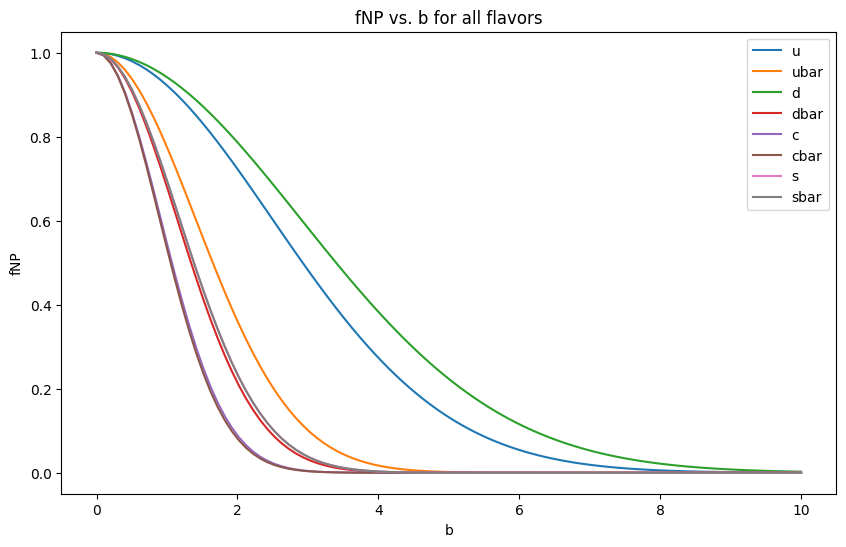

In [11]:

# Later in your fitting loop, you can update parameters:
# Assume you obtain an updated tensor (shape: 9 x max_params) from your fit.
new_params_tensor = torch.tensor([
    # Row 0: Shared evolution parameter: only first element matters, pad with zeros.
    [0.20, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],  
    # Row 1: u-quark (11 parameters)
    [0.28, 0.18, 0.14, 0.11, 0.23, 0.19, 0.09, 0.15, 0.13, 0.12, 0.10],
    # Row 2: ubar (2 parameters; remaining entries ignored)
    [0.12, 0.11, 0.10, 0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0 ],
    # Row 3: d-quark (10 parameters)
    [0.24, 0.14, 0.13, 0.06, 0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0 ],
    # Row 4: dbar (2 parameters)
    [0.22, 0.12, 0.11, 0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0 ],
    # Row 5: c-quark (2 parameters)
    [0.32, 0.22, 0.17, 0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0 ],
    # Row 6: cbar (2 parameters)
    [0.33, 0.23, 0.18, 0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0 ],
    # Row 7: s-quark (2 parameters)
    [0.21, 0.11, 0.11, 0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0 ],
    # Row 8: sbar (2 parameters)
    [0.21, 0.11, 0.11, 0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0 ]
], dtype=torch.float32)

model_fNP.set_parameters(new_params_tensor)

# Evaluate again.
results_updated = model_fNP(x, b)
print("Updated results for all flavors:")
for flavor, val in results_updated.items():
    print(f"{flavor}: {val.item()}")

# Call the plotting function again.
utl.plot_fNP(model_fNP, x)